In [413]:
import numpy as np
from numpy import array, exp, log, zeros, eye, ones

from scipy.stats import multivariate_normal as MVN
from scipy.optimize import fsolve
from scipy.optimize import minimize

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import autograd.numpy as anp
from autograd import jacobian, grad

from utils import prep_contour, ESS, ESS_univariate
from RWM import RWM
from HMC.static_hmc import HMC
from tangential_hug_functions import HugTangentialMultivariate, HugTangential

from rosenbrock_2d import RosenbrockDensity2D

# Plot Shapes

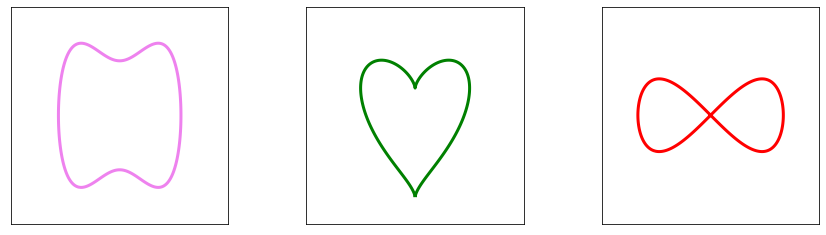

In [411]:
def f_graham(θ):
    return θ[:, 1]**2 + 3 * θ[:, 0]**2 * (θ[:, 0]**2 - 1)


def f_heart(θ):
    x, y = θ[:, 0], θ[:, 1]
    return x**2 + (y - (x**2)**(1/3))**2


def f_infinity(θ):
    x, y = θ[:, 0], θ[:, 1]
    return x**4 - x**2 + y**2

# Settings for Graham figure
xlims_g  = [-2, 2]
ylims_g  = [-2, 2]
step_g   = 0.01
levels_g = [1.0]

# Settings for Heart figure
xlims_h  = [-2, 2]
ylims_h  = [-1.5, 2.5]
step_h   = 0.01
levels_h = [1.0]

# Settings for Infinity
xlims_i  = [-1.5, 1.5]
ylims_i  = [-1.5, 1.5]
step_i   = 0.01
levels_i = [0.0]

fig, ax = plt.subplots(ncols=3, figsize=(15, 4))
# Graham
ax[0].contour(*prep_contour(xlims_g, ylims_g, step_g, f_graham), levels=levels_g, linewidths=3, colors='violet')
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_aspect('equal')
# Heart 
ax[1].contour(*prep_contour(xlims_h, ylims_h, step_h, f_heart), levels=levels_h, linewidths=3, colors='green')
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_aspect('equal')
# Infinity
ax[2].contour(*prep_contour(xlims_i, ylims_i, step_i, f_infinity), levels=levels_i, linewidths=3, colors='red')
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_aspect('equal')

plt.show()

# Plot Densities around Shapes

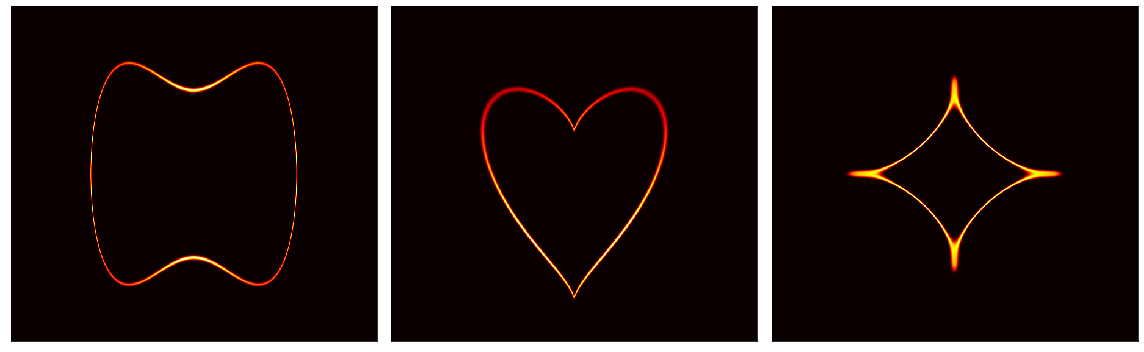

In [530]:
f_graham_broad   = lambda θ: θ[1,:,:]**2 + 3 * θ[0,:,:]**2 * (θ[0,:,:]**2 - 1)
f_heart_broad    = lambda θ: θ[0,:,:]**2 + (θ[1,:,:] - (θ[0,:,:]**2)**(1/3))**2
f_infinity_broad = lambda θ: θ[0,:,:]**4 - θ[0,:,:]**2 + θ[1,:,:]**2
f_diamond_broad  = lambda θ: (θ[0,:,:]**2 + θ[1,:,:]**2 - 1)**3 + 27*(θ[0,:,:]*θ[1,:,:])**2

σg = 0.03
σh = 0.03
σi = 0.03

logpost_g = lambda θ: -(np.sum(θ**2, 0) + (1.0 - f_graham_broad(θ))**2 / (σg)**2) / 2
logpost_h = lambda θ: -(np.sum(θ**2, 0) + (1.0 - f_heart_broad(θ))**2 / (σh)**2) / 2
logpost_i = lambda θ: -(np.sum(θ**2, 0) + (0.0 - f_diamond_broad(θ))**2 / (σi)**2) / 2

θ_grid_g = np.stack(np.meshgrid(np.linspace(-2, 2, 601), np.linspace(-2, 2, 601)))
θ_grid_h = np.stack(np.meshgrid(np.linspace(-2, 2, 601), np.linspace(-1.5, 2.5, 601)))

dens_cmap = mcolors.LinearSegmentedColormap.from_list(
    'whiteblue', [np.array((1.000, 1.000, 1.000, 1.)),
                  np.array((0.419, 0.682, 0.840, 1.)),
                  np.array((0.031, 0.188, 0.420, 1.))])

dens_cmap='hot'

fig, ax = plt.subplots(ncols=3, figsize=(16, 5))
ax[0].pcolormesh(θ_grid_g[0], θ_grid_g[1], np.exp(logpost_g(θ_grid_g)), cmap=dens_cmap, shading='auto')
ax[1].pcolormesh(θ_grid_g[0], θ_grid_g[1], np.exp(logpost_h(θ_grid_h)), cmap=dens_cmap, shading='auto')
ax[2].pcolormesh(θ_grid_g[0], θ_grid_g[1], np.exp(logpost_i(θ_grid_g)), cmap=dens_cmap, shading='auto')
# ax[1].pcolormesh(θ_grid[0], θ_grid[1], np.exp(log_posterior_dens_old(θ_grid, 0.1, 1.0)), cmap=dens_cmap, shading='auto')
# ax[2].pcolormesh(θ_grid[0], θ_grid[1], np.exp(log_posterior_dens_old(θ_grid, 0.02, 1.0)), cmap=dens_cmap, shading='auto')

for i in range(3):
 
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    plt.tight_layout()
plt.savefig('figures/filamentary_densities_for_paper.png', dpi=300)
plt.show()

# Rosenbrok

Rosenbrock **function** is
$$
f(x, y) = (a - x)^2 + b(y - x^2)^2
$$
where typically $a=1$ and $b=100$. In our case, we are using the Rosenbrock density function
$$
\pi(x, y) = \exp\left\{-\frac{(1-x)^2 + 100(y - x^2)^2}{20}\right\}
$$
which means the density is defined as $\pi(x, y) = \exp(-f(x, y) / c)$ and in this case we are setting $a=1$ and $b=100$. The minimum of the function is at $(a, a^2)$ which in this case is $(1,1)$.

In [225]:
N = 10000
RWM_stepsize = 0.1
HMC_T = 1.0
HMC_ϵ = 0.05
HUG_T = HMC_T
HUG_B = int(HMC_T / HMC_ϵ)

In [226]:
RD = RosenbrockDensity2D(c=0.1)

In [227]:
x0 = array([0.5, 0.5])

In [228]:
sRWM, aRWM = RWM(x0, RWM_stepsize, N, RD.logf)

In [229]:
hmc_sampler = HMC(x0, N, eye(2), HMC_T, HMC_ϵ)
hmc_sampler.neg_log_target = lambda x: - RD.logf(x)
hmc_sampler.dVdq = lambda x: - RD.grad_logf(x)

In [230]:
sHMC, aHMC = hmc_sampler.sample()

In [231]:
q = MVN(zeros(2), eye(2))

In [237]:
# Try using gradient of the parabola f(x, y) = x^2
# gradient of paraboloid
grad_parab = lambda xy: array([2*xy[0], -1])
sHUG, aHUG = HugTangential(x0, HUG_T, HUG_B, N, 0.0, q, RD.logf, grad_parab) #RD.grad_logf)

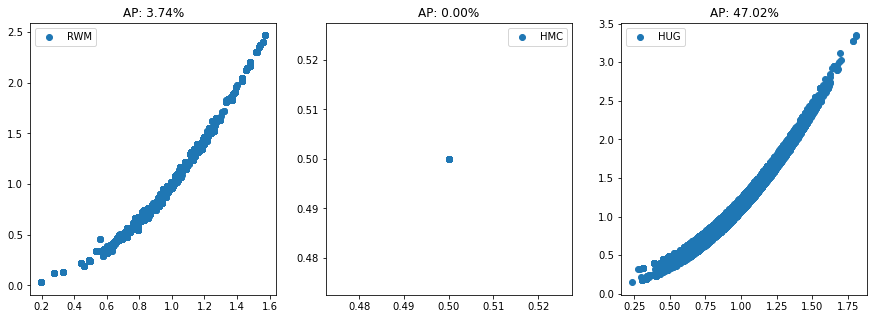

In [238]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
ax[0].scatter(*sRWM.T, label='RWM')
ax[0].set_title("AP: {:.2%}".format(aRWM.mean()))
ax[0].legend()
ax[1].scatter(*sHMC.T, label='HMC')
ax[1].set_title("AP: {:.2%}".format(aHMC.mean()))
ax[1].legend()
ax[2].scatter(*sHUG.T, label='HUG')
ax[2].set_title("AP: {:.2%}".format(aHUG.mean()))
ax[2].legend()
plt.show()

In [179]:
paraboloid = lambda xy: xy[:, 0]**2 - xy[:, 1]

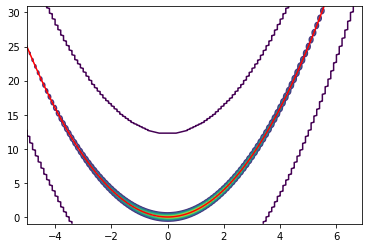

In [188]:
fig, ax = plt.subplots()
ax.contour(*prep_contour([-5, 7], [-1, 31], 0.1, RosenbrockDensity2D(c=20).f))
# Now plot contour of paraboloid with y = x^2 as one of the contours.
ax.contour(*prep_contour([-5, 7], [-1, 31], 0.1, paraboloid), levels=[0], colors='red')
plt.show()

In [161]:
RD.logf(sHMC)

array([-1.14260551, -1.70119735, -0.23851415, ..., -0.46611947,
       -4.4485752 , -0.22791552])

In [234]:
ESS_univariate(RD.logf(sHMC))

nan

In [235]:
ESS_univariate(RD.logf(sRWM))

112.64787224386033

In [236]:
ESS_univariate(RD.logf(sHUG))

134.0633382670399